# Zara Instagram Engagement

### Scraping Instagram and Getting Image Labels

This section scrapes 500 posts from Zara's Instagram page and gets the image URL, the caption, the number of likes, and the number of comments.

It then uses Google's Cloud Vision API to retrieve a set of labels for each image.

In [ ]:
!pip install instaloader
import instaloader
import pandas as pd

In [ ]:
insta = instaloader.Instaloader()
handle = 'zara'
profile = instaloader.Profile.from_username(insta.context, handle)
posts = profile.get_posts()

In [ ]:
zara_df = pd.DataFrame(columns=['url', 'caption', 'likes', 'num_comments'])
for post in posts:
    if(len(zara_df) > 500):
        break
    if post.is_video:
        continue
    zara_df.loc[len(zara_df)] = [post.url, post.caption, post.likes, post.comments]

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/text-analytics-hw3-e9a67fce5e52.json'
!pip install --upgrade google-api-python-client

In [ ]:
from google.cloud import vision
client = vision.ImageAnnotatorClient()
image = vision.Image()

def get_labels(url):
    image.source.image_uri = url
    response = client.label_detection(image=image)
    labels = response.label_annotations
    return [label.description for label in labels]

zara_df['labels'] = zara_df['url'].map(get_labels)

In [ ]:
zara_df.head()

,url,caption,likes,num_comments,labels
0,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,73078,400,"['Clothing', 'Fashion', 'Outerwear', 'Fur', 'S..."
1,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,38498,124,"['Sky', 'Darkness', 'Room', 'Adventure game', ..."
2,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,56094,192,"['Cool', 'Fashion', 'Jeans', 'Sitting', 'Denim..."
3,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34728,103,"['Hair', 'Face', 'Hairstyle', 'Eyebrow', 'Fore..."
4,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34286,187,"['Snapshot', 'Standing', 'Hand', 'Arm', 'Human..."


In [ ]:
zara_df.to_csv('zara_instagram.csv',index=False,header=True)

### Section 1

This section creates a metric for engagement by using a weighted sum of the number of likes and the number of comments.

It then splits the posts into high engagement posts and low engagement posts using the following formula:

engagement score = .4*# likes (normalized) + .6*# comments (normalized)

High engagement posts are posts with above the median engagement score while low engagement posts are posts with below the median engagement score.

In [ ]:
import pandas as pd
zara_df = pd.read_csv('zara_instagram.csv')

In [ ]:
zara_df['likes_weighted'] = zara_df['likes']/zara_df['likes'].max()
zara_df['num_comments_weighted'] = zara_df['num_comments']/zara_df['num_comments'].max()

In [ ]:
zara_df['engagement_score'] = 0.4*zara_df['likes_weighted'] + 0.6*zara_df['num_comments_weighted']
med_score = zara_df['engagement_score'].median()
zara_df['engagement_level'] = zara_df['engagement_score'].map(lambda x: 1 if x > med_score else 0)

In [ ]:
zara_df.head()

,url,caption,likes,num_comments,labels,likes_weighted,num_comments_weighted,engagement_score,engagement_level
0,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,73078,400,"['Clothing', 'Fashion', 'Outerwear', 'Fur', 'S...",0.249331,0.123229,0.173670,1
1,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,38498,124,"['Sky', 'Darkness', 'Room', 'Adventure game', ...",0.131349,0.038201,0.075460,0
2,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,56094,192,"['Cool', 'Fashion', 'Jeans', 'Sitting', 'Denim...",0.191384,0.059150,0.112044,0
3,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34728,103,"['Hair', 'Face', 'Hairstyle', 'Eyebrow', 'Fore...",0.118487,0.031731,0.066434,0
4,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34286,187,"['Snapshot', 'Standing', 'Hand', 'Arm', 'Human...",0.116979,0.057609,0.081357,0


### Section 2

In this section we run a logistic regression model to predict engagement level. We use the TF-IDF scores of the image labels as the independent variables first, and then we try using the TF-IDF of the post captions. Finally, we try combining the labels and the captions.

In [ ]:
def label_clean(labels):
    labels = labels.replace('[','')
    labels = labels.replace(']','')
    labels_clean = []
    for label in labels.split(','):
        label = label.strip()
        label = label[1:-1]
        labels_clean.append(label)
    return(' '.join(labels_clean))

zara_df['labels_clean'] = zara_df['labels'].map(label_clean)

In [ ]:
zara_df['labels_clean'].head()

0    Clothing Fashion Outerwear Fur Street fashion ...
1    Sky Darkness Room Adventure game Music venue N...
2          Cool Fashion Jeans Sitting Denim Shoe Style
3    Hair Face Hairstyle Eyebrow Forehead Chin Head...
4    Snapshot Standing Hand Arm Human Photography S...
Name: labels_clean, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(zara_df['labels_clean'])
y = zara_df['engagement_level']

Models built on image labels:


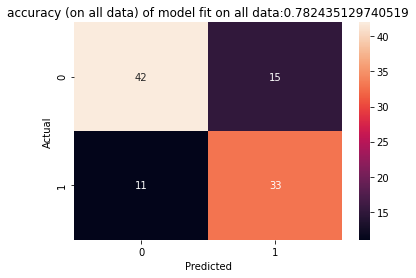

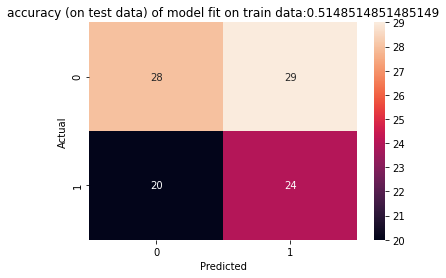

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print('Models built on image labels:')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
reg = LogisticRegression()
reg.fit(X,y)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on all data) of model fit on all data:' + str(reg.score(X,y)))
plt.show()
reg = LogisticRegression()
reg.fit(X_train,y_train)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on test data) of model fit on train data:' + str(reg.score(X_test,y_test)))
plt.show()

In [ ]:
def caption_clean(caption):
    #remove newline
    caption = caption.replace('\n',' ')
    return caption

zara_df['caption_clean'] = zara_df['caption'].map(caption_clean)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(zara_df['caption_clean'])
y = zara_df['engagement_level']

Models built on captions:


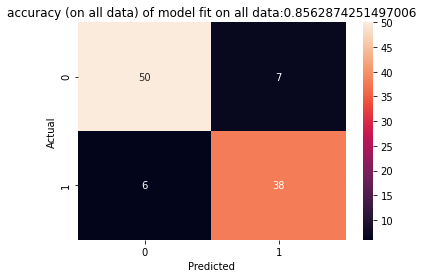

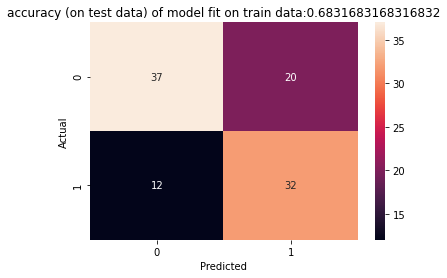

In [ ]:
print('Models built on captions:')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
reg = LogisticRegression()
reg.fit(X,y)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on all data) of model fit on all data:' + str(reg.score(X,y)))
plt.show()
reg = LogisticRegression()
reg.fit(X_train,y_train)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on test data) of model fit on train data:' + str(reg.score(X_test,y_test)))
plt.show()

In [ ]:
zara_df['labels_caption'] = zara_df['labels_clean'] + ' ' + zara_df['caption_clean']

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(zara_df['labels_caption'])
y = zara_df['engagement_level']

Models built on image labels and captions:


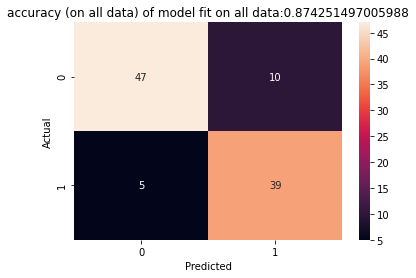

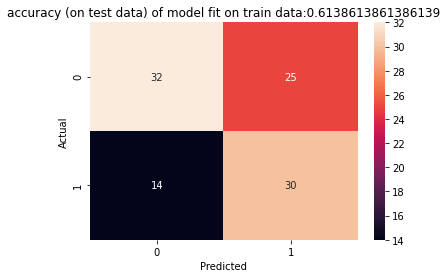

In [ ]:
print('Models built on image labels and captions:')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
reg = LogisticRegression()
reg.fit(X,y)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on all data) of model fit on all data:' + str(reg.score(X,y)))
plt.show()
reg = LogisticRegression()
reg.fit(X_train,y_train)
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
sns.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('accuracy (on test data) of model fit on train data:' + str(reg.score(X_test,y_test)))
plt.show()

##### Takeaway

Captions seem to be a much better predictor of engagement than labels. This implies that the caption of an instagram post is more important than what is actually depicted in the picture, a very interesting finding.

### Section 3

In this section, we perform topic modeling on the image labels using LDA. We then try to find the topics with the highest engagement by looking at the topics among the posts in the top quartile for engagement and the bottom quartile for engagement.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(zara_df['labels_clean'])

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 3
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=4)
lda.fit(count_data)
# Print the topics
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
hair beauty photo shoot hairstyle model skin sitting photography long

Topic #1:
photography black white and monochrome photograph sitting pattern cool design

Topic #2:
fashion clothing outerwear shoulder dress leg model sleeve standing footwear


3 topics seems to be a good number as they are differentiable but not too noisy. Topic names could be as follows:

Topic 0: Beauty

Topic 1: Photography

Topic 2: Fashion/Clothing

In [ ]:
loading_df = pd.DataFrame(lda.components_.T, index=count_vectorizer.get_feature_names())
loading_df.columns = ['beauty', 'photography', 'fashion/clothing']

In [ ]:
loading_df.sort_values(by='beauty', ascending=False).head()

,beauty,photography,fashion/clothing
hair,132.312573,0.342586,0.344840
beauty,89.288428,1.985076,29.726496
photo,66.785567,0.780806,15.433627
shoot,64.688283,0.492901,15.818816
hairstyle,53.297227,0.346268,0.356505


In [ ]:
loading_df.sort_values(by='photography', ascending=False).head()

,beauty,photography,fashion/clothing
photography,39.580544,136.969926,14.449530
black,8.541599,101.269071,27.189330
white,8.739731,100.791256,52.469013
and,0.347139,71.432473,1.220388
monochrome,0.343494,51.320894,0.335613


In [ ]:
loading_df.sort_values(by='fashion/clothing', ascending=False).head()

,beauty,photography,fashion/clothing
fashion,31.832422,5.811538,314.356041
clothing,0.567681,0.344820,194.087499
outerwear,0.421125,0.987043,170.591833
shoulder,37.561988,0.744380,96.693632
dress,5.510581,0.445786,85.043633


(i) loading_df is a dataframe showing which words load on which topics

The topics have substantially different loadings for each word, showing that 3 topics is an appropriate amount without a large amount of overlap.

In [ ]:
zara_df_topics = zara_df.merge(pd.DataFrame(lda.transform(count_data), 
                           columns=['beauty','photography','fashion/clothing']),
              left_index=True, right_index=True)
zara_df_topics.head()

,url,caption,likes,num_comments,labels,likes_weighted,num_comments_weighted,engagement_score,engagement_level,labels_clean,caption_clean,labels_caption,beauty,photography,fashion/clothing
0,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,73078,400,"['Clothing', 'Fashion', 'Outerwear', 'Fur', 'S...",0.249331,0.123229,0.173670,1,Clothing Fashion Outerwear Fur Street fashion ...,FW20 Campaign. Kids Collection Creative Direct...,Clothing Fashion Outerwear Fur Street fashion ...,0.027067,0.058122,0.914811
1,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,38498,124,"['Sky', 'Darkness', 'Room', 'Adventure game', ...",0.131349,0.038201,0.075460,0,Sky Darkness Room Adventure game Music venue N...,FW20 Campaign. Kids Collection Creative Direct...,Sky Darkness Room Adventure game Music venue N...,0.344325,0.631707,0.023968
2,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Kids Collection\nCreative Direc...,56094,192,"['Cool', 'Fashion', 'Jeans', 'Sitting', 'Denim...",0.191384,0.059150,0.112044,0,Cool Fashion Jeans Sitting Denim Shoe Style,FW20 Campaign. Kids Collection Creative Direct...,Cool Fashion Jeans Sitting Denim Shoe Style FW...,0.044959,0.418802,0.536239
3,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34728,103,"['Hair', 'Face', 'Hairstyle', 'Eyebrow', 'Fore...",0.118487,0.031731,0.066434,0,Hair Face Hairstyle Eyebrow Forehead Chin Head...,FW20 Campaign. Man Collection Creative Directi...,Hair Face Hairstyle Eyebrow Forehead Chin Head...,0.938907,0.030519,0.030574
4,https://scontent-iad3-1.cdninstagram.com/v/t51...,FW20 Campaign. Man Collection\nCreative Direct...,34286,187,"['Snapshot', 'Standing', 'Hand', 'Arm', 'Human...",0.116979,0.057609,0.081357,0,Snapshot Standing Hand Arm Human Photography S...,FW20 Campaign. Man Collection Creative Directi...,Snapshot Standing Hand Arm Human Photography S...,0.423618,0.546903,0.029479


(ii) The zara_df_topics dataframe shows topic weights for each image - shown in the last 3 columns of the dataframe.

In [ ]:
import numpy as np
top_quartile = np.percentile(zara_df_topics['engagement_score'], 75)
bottom_quartile = np.percentile(zara_df_topics['engagement_score'], 25)
print(top_quartile, bottom_quartile)

0.20215605548505378 0.1039188588326993


In [ ]:
print('top quartile topic means:')
print(zara_df_topics[zara_df_topics['engagement_score'] > top_quartile][['beauty', 'photography', 'fashion/clothing']].mean())
print('\nbottom quartile topic means:')
print(zara_df_topics[zara_df_topics['engagement_score'] < bottom_quartile][['beauty', 'photography', 'fashion/clothing']].mean())

top quartile topic means:
beauty              0.306642
photography         0.156145
fashion/clothing    0.537213
dtype: float64

bottom quartile topic means:
beauty              0.272016
photography         0.365265
fashion/clothing    0.362719
dtype: float64


### Section 4

What advice could we give Zara if it wants to increase engagement on its Instagram page based on your findings in Sections 2 and 3?

Based on the findings from Section 2, it seems that Zara should focus much more effort on its captions. The findings from task B suggest that what is depicted in the image itself is actually less important than what is in the caption. While it is still important to post relevant and high-quality content, Zara's social media team should put a little more effort into determining the best possible captions.

Based on the findings from Section 3, it seems that the posts that have the most engagement can be classified as belonging more to a "fashion" topic than posts with low engagement. This implies that people engage more with pictures that showcase the fashion of Zara. On the other hand, low engagment pictures belong to the "photography" topic more than high engagement posts. This could imply that users are less concerned with how artistic or good the picture actually is than other aspects. Posts that seem to focus on the photography rather than the fashion seem to have lower engagement.

Overall, our suggestion to Zara would be to focus more on the caption of the post, and also post more pictures showcasing their fashion while not worrying about how good/artistic the photos actually are.